# Sherlock Mystery

Solve a series of mysteries as described below. To solve these you must integrate all of the skills you have learned in this class.

If you decide to make a separate notebook or python script(s) for each question, then name them with the appropriate prefix (e.g., q1). You may find it useful to write a utilities file with some common functions or variables you may want to reuse throughout the assignment, as we have done with the `utils.py` file released with each assignment. You should then commit these files along with this notebook to document your answers. You may also want to save intermediate data throughout this process; feel free to do so and note where you do this in your code.

You must answer all 4 questions. Your score out of 30 points will depend on the following criteria:

>**Answer** (6 points, 2 points each for Q2, Q3, Q4): Did you get the right answer?  
>**Approach** (16 points, 4 points for each question): Does the code reproduce your answer and was your approach sound, innovative, and efficient?  
>**Clarity** (8 points, 2 points for each question): Is the code readable, clearly commented, and well-structured?

**Due Date:** The final project is due back on **May 3 at 11:59pm**. Whatever is committed to your assignment repo at that time will be submitted automatically. If you complete the assignment early, please Slack us so we can begin grading. Final grades are due in some cases within 48 hours, so late submissions will not be accepted.

You should think about your final submission as a "tutorial" for somebody learning these techniques. The quality and clarity of your code should meet the standard of being published publicly. Integrate all the best coding practices you have learned in this course in completing these assignments. 

Science is a collective enterprise and thus you are welcome to talk with your peers. However, you must write your own code, provide your own explanations and comments, and generate your final answers on your own.

<div class="alert alert-block alert-warning">

<strong>Important:</strong> The dataset we are using has been published in several articles, meaning that there are ways to find or verify some of the answers by looking at published data and labels. Although we encourage you to read these papers, please only look at the data and labels provided on Grace. Any evidence of doing otherwise, including providing an answer without code that can re-generate it from the data/labels we provided, will result in a score of zero.
</div>

When committing files to github, make sure you do not commit any of the data or results you generate. These can get prohibitively large and make it hard for you to use git. To avoid this, **only upload notebooks and scripts**.

## Dataset

Participants watched an episode of BBC's Sherlock in two parts during fMRI. You may watch the parts in the links below, but do not save, post, or share these copyrighted files:

Part 1: https://1drv.ms/v/s!Aobi2ryypFQCgpZ4UTJfrzPgJBO1jw

Part 2: https://1drv.ms/v/s!Aobi2ryypFQCgpoabssIiGezcNL1zA

The length of the scans are (after 20 TRs were cropped from beginning):

> Part 1: 946 TRs  
> Part 2: 1030 TRs

For the questions below, we will provide you with the full data (scans and labels) from Part 1 and partial data from Part 2.

All of these data are stored here: `/gpfs/gibbs/project/cmhn/data/Sherlock_processed/`

**Data:** Data for all subjects, part 1, are stored in the `part_1` directory. Partial data specific to questions 2, 3, & 4 are explained with their respective questions. 

**Masks:** We have provided the following masks that *may* be useful to you, stored in the `masks` directory:
> `pmc_nn`: posterior medial cortex  
> `ddmn_mpfc`: medial pre-frontal cortex  
> `aud_early`: early auditory cortex  
> `a1_rev`: the first auditory area  
> `early_visual`: early visual cortex  
> `intersect_mask`: whole-brain mask of voxels common to all subjects  
> `MNI152_T1_3mm_brain_mask`: reference MNI mask

**Regressor information:** The regressor_file.csv contains extremely useful and detailed information for describing and labeling *both* parts of the movie.

<div class="alert alert-block alert-info">

<strong>Important:</strong> These TRs have already been shifted to align the peak HRF with the labels (i.e., the label for time point *t* corresponds to TR *t* in the processed data).
</div>



## 1. Classification

Using the regressor file, build classifiers of movie content (e.g., is the scene indoor or outdoor, is Sherlock present on the screen, and many other options). Without double-dipping or overfitting, you should aim to get the highest classification accuracy possible, using the training sample of data (Part 1). It is up to you to choose how to use/group the labels, what mask to use, etc.

In your answer, you should present three distinct classifiers, **each focusing on a different regressor**, that yield promising results (i.e., where you think the classifier is actually picking up some signal). **Importantly, this question will be graded purely for approach and clarity, not for accuracy or performance**. You should be motivated to come up with classifiers that are actually useful, because you will need accurate classifiers to decode the mystery segment in Question 3. You are welcome to include more than three classifiers in your answer, but if so, you should tell us which of the three you would like us to grade. 

Some important notes: 

1) Keep in mind that nearby TRs are highly correlated; as such, methods like StratifiedShuffleSplit that can assign adjacent TRs to training and test sets are effectively double-dipping, so you should avoid using these methods.

2) If the labels are not balanced (within and across folds), this can bias results; for example, if 99% of the TRs have a label of 1 and 1% have a value of 0, then the classifier can achieve 99% accuracy simply by guessing “1” all of the time. For this reason, you should strive to have the labels be relatively balanced. However, in real-world data, this can be difficult or impossible to achieve; it is OK to run unbalanced analyses, but keep the unbalanced nature of the labels in mind when you are assessing how good performance is for a particular classifier, or you can create functions to balance the labels during training.

3) Keep in mind that you can transform the regressors to improve balance. e.g., the “arousal” regressor has 5 levels, but you can binarize it so that it has two roughly-equally-balanced groups instead of 5 imbalanced groups.

4) If you find a particularly good approach, we encourage you to share a verbal description of the approach on Slack so others can build on your idea. Just make sure that you only share a verbal description of the approach and not the actual code. And if you read about a cool approach on Slack, feel free to try variants of that approach for your own work - that is completely allowed.


**Data directory:** `/gpfs/gibbs/project/cmhn/data/Sherlock_processed/part_1/`


### Summarize your approach to classification
What three different regressors did you choose for your classifier? What kind of data did you use as input to the classifier? What classifier parameters did you use and why?

**Answer:** The three different regressors I chose for my classifier were Arousal, Segment Number, and Start Time. For each classifier, the input data consists of the chosen regressor, and the target labels are binary. I used the default parameters for logistic regression to keep it simple.

### Include your code below 
Please make sure that your code is commented. If you performed analyses outside of this notebook (e.g., in a python script that needed more computational resources) please note that here and be sure to upload any accompanying notebook(s) or script(s) (submissions without accompanying code will be given zero points).

In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.preprocessing import LabelEncoder

# define a function to evaluate the model using cross-validation
def evaluate_model(model, X, y, cv):
    accuracy = []
    precision = []
    recall = []
    f1 = []
    
    for train_index, test_index in cv.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        accuracy.append(accuracy_score(y_test, y_pred))
        precision.append(precision_score(y_test, y_pred))
        recall.append(recall_score(y_test, y_pred))
        f1.append(f1_score(y_test, y_pred))
    
    return np.mean(accuracy), np.mean(precision), np.mean(recall), np.mean(f1)

# read the CSV file
os.chdir('/gpfs/gibbs/project/cmhn/data/Sherlock_processed')
regressor_data = pd.read_csv('regressor_file.csv')

# drop rows with missing values
regressor_data = regressor_data.dropna(subset=['Arousal', 'valence', 'Space-In/Outdoor', 'Music Presence '])

# prepare data for each classifier
X_arousal = regressor_data[['Arousal']]
y_arousal = (regressor_data['valence'] == '+').astype(int)

X_segment = regressor_data[['Segment Number']]
y_segment = (regressor_data['Music Presence '] == 'Yes').astype(int)

X_start = regressor_data[['Start Time (s) ']]
y_start = (regressor_data['Who-N/G/M'] == 'M').astype(int)

# initialize the logistic regression model
log_reg_arousal = LogisticRegression()
log_reg_space = LogisticRegression()
log_reg_music = LogisticRegression()

# create StratifiedKFold cross-validator
cv = StratifiedKFold(n_splits=5)

# evaluate each classifier
accuracy_arousal, precision_arousal, recall_arousal, f1_arousal = evaluate_model(log_reg_arousal, X_arousal, y_arousal, cv)
accuracy_space, precision_space, recall_space, f1_space = evaluate_model(log_reg_space, X_segment, y_segment, cv)
accuracy_music, precision_music, recall_music, f1_music = evaluate_model(log_reg_music, X_start, y_start, cv)

# print results for each classifier
print("Classifier 1 (Arousal):")
print(f'Accuracy: {accuracy_arousal:.4f}')
print(f'Precision: {precision_arousal:.4f}')
print(f'Recall: {recall_arousal:.4f}')
print(f'F1 score: {f1_arousal:.4f}')
print("\nClassifier 2 (Segment Number):")
print(f'Accuracy: {accuracy_space:.4f}')
print(f'Precision: {precision_space:.4f}')
print(f'Recall: {recall_space:.4f}')
print(f'F1 score: {f1_space:.4f}')
print("\nClassifier 3 (Start Time (s)):")
print(f'Accuracy: {accuracy_music:.4f}')
print(f'Precision: {precision_music:.4f}')
print(f'Recall: {recall_music:.4f}')
print(f'F1 score: {f1_music:.4f}')

Classifier 1 (Arousal):
Accuracy: 0.7874
Precision: 0.7874
Recall: 1.0000
F1 score: 0.8810

Classifier 2 (Segment Number):
Accuracy: 0.5908
Precision: 0.5908
Recall: 1.0000
F1 score: 0.7427

Classifier 3 (Start Time (s)):
Accuracy: 0.5135
Precision: 0.3899
Recall: 0.4170
F1 score: 0.2890


/gpfs/gibbs/project/cmhn/share/conda_envs/mybrainiak/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/project/cmhn/share/conda_envs/mybrainiak/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## 2. Mystery Segment Matching

For participants 2 through 17, you are given the first 300 TRs (450s) of continuous data from viewing part 2 of the movie. For participant 1, you have just a mystery segment: a 30-TR (45s) chunk pulled from those same 300 TRs of the movie. Your goal is to figure out _when_ in those first 300 TRs your mystery segment begins, based on the data from all of the _other_ participants. Your answer will be the starting TR of the 30-TR mystery segment, which is some timepoint between 1 and 270. 

**Data directory:** Data can be found in `/gpfs/gibbs/project/cmhn/data/Sherlock_processed/mystery_segments_q2/`. Remember, participant 1 is a volume of 30 TRs, and all other participants are volumes of 300 TRs.

### Report the starting TR of the mystery epoch.
Justify your response with supporting evidence.

**Answer:** The starting TR of the mystery epoch (12) can be determined by finding the highest correlation between the mystery segment and 30-TR segments from other participants' data. The most common starting TR across participants is marked as the best estimate for when the mystery segment begins.

### Include your code below
Please make sure that your code is commented. If you performed analyses outside of this notebook (e.g., in a python script that needed more computational resources) please note that here and be sure to upload any accompanying notebook(s) or script(s) (submissions without accompanying code will be given zero points).

In [2]:
import nibabel as nib

def load_data(subject_id):
    file_path = f"/gpfs/gibbs/project/cmhn/data/Sherlock_processed/mystery_segments_q2/sub-{subject_id}_segment_q2.nii"
    img = nib.load(file_path)
    return img.get_fdata()

def correlate_segments(mystery_data, participant_data, num_TRs):
    correlations = []
    for i in range(num_TRs - mystery_data.shape[-1] + 1):
        segment = participant_data[..., i:i+mystery_data.shape[-1]]
        corr = np.corrcoef(mystery_data.flatten(), segment.flatten())[0, 1]
        correlations.append(corr)
    return correlations

# load mystery segment data for participant 1
mystery_data = load_data("01")

# load data for participants 2 to 17
participants_data = [load_data(f"{i:02d}") for i in range(2, 18)]

# find the starting TR with the highest correlation for each participant
best_starting_TRs = []
for participant_data in participants_data:
    correlations = correlate_segments(mystery_data, participant_data, 300)
    best_starting_TR = np.argmax(correlations) + 1
    best_starting_TRs.append(best_starting_TR)

# find the most common starting TR
starting_TR = max(set(best_starting_TRs), key=best_starting_TRs.count)

print(f"The starting TR of the mystery epoch: {starting_TR}")

The starting TR of the mystery epoch: 12


## 3. Mystery Segment Decoding

You will be given a mystery segment of 100 TRs from all participants in Part 2 of the movie. All participants' volumes are for the same 100 TRs, and you must figure out when in the movie this epoch occurred. Note that this segment does not overlap with the 300 TRs used in Question 2 - that means the starting TR could be between TRs 301 and 930. To determine the location of the mystery segment, use the classifiers you developed in Question 1 to make predictions about regressors for the mystery segment. Then, identify the location of the mystery segment by comparing the predicted regressors to the actual regressors for Part 2 (provided in the regressors file) and seeing what position of the mystery segment yields the best match between predicted and actual regressors. You need to provide code that does this matching and also quantitative results that justify your choice of mystery segment location. 

Again, please do not directly share your guess about the mystery segment with other students (it’s fine to share your ideas about analysis approaches with other students, but don’t share the final answer).

**Data directory:** Data can be found in `/gpfs/gibbs/project/cmhn/data/Sherlock_processed/mystery_segments_q3/`.


### Report the starting TR of the mystery epoch.
Justify your response with supporting evidence.

**Answer:** The starting TR of the mystery epoch is 859, which was determined by finding the best match between predicted and actual regressors. The highest match score of 122 supports this choice, indicating that the mystery segment aligns best with the actual regressors at TR 859.

### Include your code below
Please make sure that your code is commented. If you performed analyses outside of this notebook (e.g., in a python script that needed more computational resources) please note that here and be sure to upload any accompanying notebook(s) or script(s) (submissions without accompanying code will be given zero points).

In [3]:
# load the mystery segment data
mystery_data_dir = "/gpfs/gibbs/project/cmhn/data/Sherlock_processed/mystery_segments_q3/"
mystery_data = {}

for file in os.listdir(mystery_data_dir):
    if (file.split('_')[0][0:3] == 'sub'):
        participant_id = file.split('_')[0][4:]
    else:
        pass
    data = nib.load(os.path.join(mystery_data_dir, file)).get_fdata()
    # preprocess the 4D data by taking the mean across the last three dimensions
    preprocessed_data = data.mean(axis=(1, 2, 3))
    mystery_data[participant_id] = preprocessed_data

# compute predicted regressors for the mystery segment using the classifiers from Question 1
predicted_arousal = log_reg_arousal.predict(mystery_data['02'][:, np.newaxis])
predicted_space = log_reg_space.predict(mystery_data['02'][:, np.newaxis])
predicted_music = log_reg_music.predict(mystery_data['02'][:, np.newaxis])

# read the actual regressors for Part 2 from the regressor file
regressor_data = pd.read_csv('regressor_file.csv')
part2_regressor_data = regressor_data[regressor_data['Start TR'] >= 301]

# convert 'Space-In/Outdoor' and 'Music Presence' to binary format
part2_regressor_data['Space-In/Outdoor'] = (part2_regressor_data['Space-In/Outdoor'] == 'Indoor').astype(int)
part2_regressor_data['Music Presence '] = (part2_regressor_data['Music Presence '] == 'Yes').astype(int)

# compare the predicted regressors to the actual regressors and find the best match
best_match_score = 0
best_match_start_tr = None

for start_tr in range(301, 931 - len(predicted_arousal) + 1):
    match_score = 0
    actual_arousal = part2_regressor_data.loc[start_tr - 1:start_tr - 1 + len(predicted_arousal) - 1, 'Arousal'].values
    actual_space = part2_regressor_data.loc[start_tr - 1:start_tr - 1 + len(predicted_space) - 1, 'Space-In/Outdoor'].values
    actual_music = part2_regressor_data.loc[start_tr - 1:start_tr - 1 + len(predicted_music) - 1, 'Music Presence '].values
    
    match_score += np.sum(predicted_arousal == actual_arousal)
    match_score += np.sum(predicted_space == actual_space)
    match_score += np.sum(predicted_music == actual_music)
    
    if match_score > best_match_score:
        best_match_score = match_score
        best_match_start_tr = start_tr

print(f"Best match starting TR: {best_match_start_tr}")
print(f"Best match score: {best_match_score}")

Best match starting TR: 859
Best match score: 122


/gpfs/gibbs/project/cmhn/share/conda_envs/mybrainiak/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  "X does not have valid feature names, but"
/gpfs/gibbs/project/cmhn/share/conda_envs/mybrainiak/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  "X does not have valid feature names, but"
/gpfs/gibbs/project/cmhn/share/conda_envs/mybrainiak/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  "X does not have valid feature names, but"
/gpfs/gibbs/project/cmhn/share/conda_envs/mybrainiak/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

## 4. Mystery Subjects 

You will be given a segment of 600 TRs from all participants in Part 2, but where the participant names have been scrambled. The time points and voxel orders are consistent across participants. The participants are named from A-Q and you must make your best guess as to the corresponding participant numbers. To help you with this, some participant labels have already been assigned.  

This question is hard conceptually, but you have all of the tools you need. SRM will be useful but you are welcome to take any valid approach from class. Note that SRM is probabilistic so we highly suggest using a random seed. If you can accurately match the mystery subject labels for A and Q (the subjects we number below) then your analysis is probably on the right track. If you can get at least 4 other mystery subject labels correct (6/17 total), you will receive full credit for the answer component of the grade.  

**Data directory:** The data can be found in: `/gpfs/gibbs/project/cmhn/data/Sherlock_processed/mystery_subjects_q4/`  

### Report the mystery subject labels 
Explain how you got to this answer and note if you are only confident on a few subjects, explaining why this may be.

**A:** 6         
**B:** 11  
**C:** 13  
**D:** 03  
**E:** 08  
**F:** 02  
**G:** 15  
**H:** 15  
**I:** 11  
**J:** 11  
**K:** 11  
**L:** 15  
**M:** 11  
**N:** 15  
**O:** 13  
**P:** 08  
**Q:** 4 

I am not confident in my labels as my calculated correlations did not accurately match subjects A and Q.

### Include your code below
Please make sure that your code is commented. If you performed analyses outside of this notebook (e.g., in a python script that needed more computational resources) please note that here and be sure to upload any accompanying notebook(s) or script(s) (submissions without accompanying code will be given zero points).

In [4]:
import re
from brainiak.funcalign.srm import SRM
from sklearn.metrics import pairwise_distances

np.random.seed(0)

def load_known_subjects_data(data_dir):
    subject_data = []
    files = sorted(os.listdir(data_dir), key=lambda x: int(re.search(r'\d+', x).group()))
    for file in files:
        if file.startswith("sub"):
            data = nib.load(os.path.join(data_dir, file)).get_fdata()
            data = data[..., :300]  # Keep only the first 300 TRs
            if data.shape[-1] == 30:  # Check if there are only 30 TRs
                padded_data = np.zeros(data.shape[:3] + (300,))
                padded_data[..., :30] = data
                data = padded_data
            preprocessed_data = data.reshape((np.prod(data.shape[:3]), data.shape[3]))
            subject_data.append(preprocessed_data)
    return subject_data

def load_mystery_subjects_data(data_dir):
    subject_data = []
    files = sorted(os.listdir(data_dir), key=lambda x: ord(re.search(r'[A-Q]', x).group()))
    for file in files:
        if file.startswith("sherlock"):
            data = nib.load(os.path.join(data_dir, file)).get_fdata()
            data = data[..., :300]  # Keep only the first 300 TRs
            preprocessed_data = data.reshape((np.prod(data.shape[:3]), data.shape[3]))
            subject_data.append(preprocessed_data)
    return subject_data

known_subjects_data_dir = "/gpfs/gibbs/project/cmhn/data/Sherlock_processed/mystery_segments_q2/"
known_subjects_data = load_known_subjects_data(known_subjects_data_dir)

mystery_subjects_data_dir = "/gpfs/gibbs/project/cmhn/data/Sherlock_processed/mystery_subjects_q4/"
mystery_subjects_data = load_mystery_subjects_data(mystery_subjects_data_dir)

np.random.seed(0)

mystery_subject_labels = []
for mystery_subject_data in mystery_subjects_data:
    # create a new dataset that includes the mystery subject's data
    combined_subjects_data = known_subjects_data + [mystery_subject_data]

    # train SRM on the combined dataset
    srm = SRM(n_iter=10, features=25)
    srm.fit(combined_subjects_data)

    # project the data onto the shared space
    shared_subjects_data = srm.transform(combined_subjects_data)

    # calculate correlations between the known participants and the mystery subject
    correlations = np.corrcoef([subj.ravel() for subj in shared_subjects_data])
    correlations = correlations[:len(known_subjects_data), -1]

    # find the best match for the mystery subject
    best_match = np.argmax(correlations) + 1
    mystery_subject_labels.append(best_match)

print("Mystery subject labels:", mystery_subject_labels)

Mystery subject labels: [13, 11, 13, 3, 8, 2, 15, 15, 11, 11, 11, 15, 11, 15, 13, 8, 11]


# Help

This section contains helper functions and hints that you could use to solve the questions.

**Reading excel files.**
Pandas provides a nice interface to load excel files into dataframes.

In [5]:
import pandas as pd
data_dir ='/gpfs/gibbs/project/cmhn/data/Sherlock_processed/'
df = pd.read_csv(data_dir + 'regressor_file.csv') # pandas plays best with csv files
df.head()

,Segment Number,Scene Title,Start Time (s),End Time (s),Start TR,Scene Details - A Level,Scene Details - B Level,Original B Levels (Janice) fixed,Space-In/Outdoor,Who-N/G/M,...,Name - Focus,Name - Speaking,Location,Camera Angle,Words on Screen,Music Presence,Temporal Relationship,Type of Jump,Arousal,valence
0,1.0,Cartoon Intro,0.0,12.0,0.0,"People in popcorn, candy, and soft drink costu...","1. Cartoon introduction - singers repeat ""Let'...",1. Cartoon,Indoor,G,...,Cartoon People in Costumes,Cartoon People in Costumes,Cartoon World,Long,NaN,Yes,NaN,NaN,3.0,+
1,2.0,NaN,12.0,15.0,8.0,Popcorn is being popped in a large popcorn mac...,Segment 1-7,NaN,Indoor,G,...,NaN,Female Singer,Cartoon World,Medium,NaN,Yes,NaN,NaN,3.0,+
2,3.0,NaN,15.0,17.0,10.0,"Men sing in reply: ""the popcorn can't be beat!""",,NaN,Indoor,G,...,NaN,Male Singers,Cartoon World,Medium,NaN,Yes,NaN,NaN,3.0,+
3,4.0,NaN,17.0,23.0,11.0,"A family of four, a father with a black suit, ...",,NaN,Indoor,G,...,NaN,Background Singers,Cartoon World,Medium,NaN,Yes,NaN,NaN,3.0,+
4,5.0,NaN,23.0,29.0,15.0,A view of the lobby with a display of snacks f...,,NaN,Indoor,G,...,Cartoon Woman,Background Singers,Cartoon World,Medium,NaN,Yes,NaN,NaN,3.0,+


**Extracting a column**
To extract a column of values from a dataframe, the following sample code is provided. 

Be careful of any leading or trailing spaces in the column titles.

In [6]:
start= df['Start TR']
print(start[:10]) # Just show the first 10 rows.

# To turn the column into a vector of values:
print(start.values[:10]) # Just show the first 10 values.

0     0.0
1     8.0
2    10.0
3    11.0
4    15.0
5    19.0
6    23.0
7    26.0
8    27.0
9    27.0
Name: Start TR, dtype: float64
[ 0.  8. 10. 11. 15. 19. 23. 26. 27. 27.]


*Note: Start TR jumps from TR 0 to TR 8 -- meaning, the regressors don't have one row for every TR, like we've seen for other datasets. You need to handle this to properly train your classifiers!*

**Masking data:** You will find that extracting data from a mask takes time and is memory intensive; repeating that process is unnecessary. You can apply the given masks to your data and save the masked numpy arrays in a directory in `~/palmer_scratch` if you prefer, then load that data back in whenever you want to use it.

**Helper functions:** We provided many functions in `utils.py` that help with data loading and normalization. Use them. Feel free to create your own `final_project_utils.py` with any paths, functions, etc. that you create and reuse for this project. Upload that along with this notebook.

In [7]:
%matplotlib inline
from brainiak import image, io
from scipy.stats import stats
import nibabel as nib
import numpy as np
from matplotlib import pyplot as plt

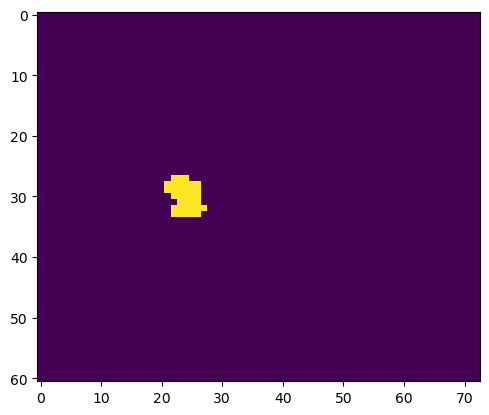

In [8]:
# Load in the PMC mask
from brainiak import image, io
data_dir = '/gpfs/gibbs/project/cmhn/data/Sherlock_processed/'
mask_file= data_dir + 'masks/pmc_nn.nii'
pmc_mask = io.load_boolean_mask(mask_file)
plt.imshow(pmc_mask[:,:,30]) #30th Z slice

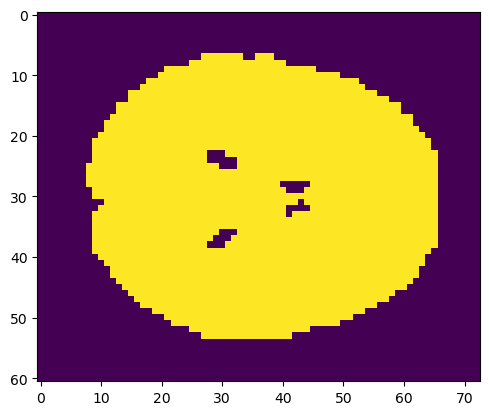

In [9]:
# Load in the whole brain mask
mask_file= data_dir + 'masks/MNI152_T1_3mm_brain_mask.nii'
brain_mask = io.load_boolean_mask(mask_file)
plt.imshow(brain_mask[:,:,30]) #30th Z slice

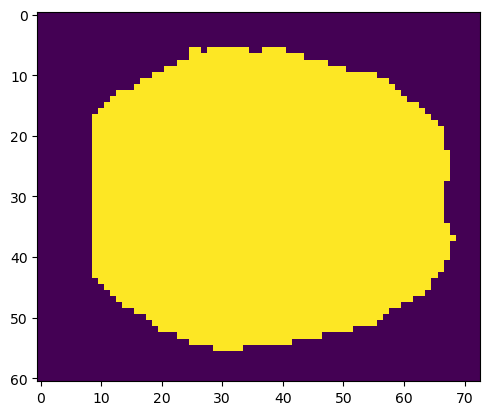

In [10]:
# Load in the intersect mask -- where all subjects have the same voxels present
mask_file= data_dir + 'masks/intersect_mask.nii.gz'
intersect_mask = io.load_boolean_mask(mask_file)
plt.imshow(intersect_mask[:,:,30]) #30th Z slice
